<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv4/blob/main/get_manipulation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import collections
import re
import numpy as np
import gdown

In [2]:

download_links = ['https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/vocabulary.pkl',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/vocabulary_info.pkl',
]


output_filepath = '/content/'
for link in download_links:
  gdown.download(link, output_filepath)

Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/vocabulary.pkl
To: /content/vocabulary.pkl
1.52MB [00:00, 11.3MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/drebin/vocabulary_info.pkl
To: /content/vocabulary_info.pkl
2.90MB [00:00, 18.8MB/s]                          


In [3]:


# Open the .pkl file
with open('/content/vocabulary.pkl', 'rb') as f:
    # Load the object
    vocabulary = pickle.load(f)

# Close the file
f.close()

print(len(vocabulary))

# Open the .pkl file
with open('/content/vocabulary_info.pkl', 'rb') as f:
    # Load the object
    info = pickle.load(f)

# Close the file
f.close()

print(len(info))

10000
10000


In [4]:
vocabulary[:5]

[b'RequestedPermissionList_android.permission.READ_PHONE_STATE',
 b'IntentFilterList_android.intent.action.BOOT_COMPLETED',
 b'RequestedPermissionList_android.permission.SEND_SMS',
 b'RestrictedApiList_android.telephony.TelephonyManager.getDeviceId',
 b'RequestedPermissionList_android.permission.RECEIVE_BOOT_COMPLETED']

In [5]:
# Remove "b" from the beginning of each element
vocab = [element.decode('utf-8') for element in vocabulary]
vocab[:5]

['RequestedPermissionList_android.permission.READ_PHONE_STATE',
 'IntentFilterList_android.intent.action.BOOT_COMPLETED',
 'RequestedPermissionList_android.permission.SEND_SMS',
 'RestrictedApiList_android.telephony.TelephonyManager.getDeviceId',
 'RequestedPermissionList_android.permission.RECEIVE_BOOT_COMPLETED']

In [6]:
info

defaultdict(set,
            {b'ActivityList_com.androidupgrade.battery.TabHandler': {'com.androidupgrade.battery.TabHandler'},
             b'ActivityList_com.GUvJEN.OnjJGwiIhldTF': {'com.GUvJEN.OnjJGwiIhldTF'},
             b'BroadcastReceiverList_.backend.Bootstrapper': {'.backend.Bootstrapper'},
             b'ServiceList_com.zs.terence.service.ScreenStateService': {'com.zs.terence.service.ScreenStateService'},
             b'IntentFilterList_org.davidliebman.android.awesomeguy.Credits': {'org.davidliebman.android.awesomeguy.Credits'},
             b'ServiceList_com.hddevs.matajilwp.Wallpaper': {'com.hddevs.matajilwp.Wallpaper'},
             b'ActivityList_.RuleActivity': {'.RuleActivity'},
             b'ServiceList_com.battery.savior.service.AggressiveService': {'com.battery.savior.service.AggressiveService'},
             b'ActivityList_.ThemePattern': {'.ThemePattern'},
             b'ActivityList_com.mobilegrub.android.PaymentAccountLoginActivity': {'com.mobilegrub.android.Pa

In [7]:
# Remove "b" from the beginning of each key
vocab_info = {key.decode('utf-8'): value for key, value in info.items()}

# Print the modified dictionary
print(vocab_info)

{'ActivityList_com.androidupgrade.battery.TabHandler': {'com.androidupgrade.battery.TabHandler'}, 'ActivityList_com.GUvJEN.OnjJGwiIhldTF': {'com.GUvJEN.OnjJGwiIhldTF'}, 'BroadcastReceiverList_.backend.Bootstrapper': {'.backend.Bootstrapper'}, 'ServiceList_com.zs.terence.service.ScreenStateService': {'com.zs.terence.service.ScreenStateService'}, 'IntentFilterList_org.davidliebman.android.awesomeguy.Credits': {'org.davidliebman.android.awesomeguy.Credits'}, 'ServiceList_com.hddevs.matajilwp.Wallpaper': {'com.hddevs.matajilwp.Wallpaper'}, 'ActivityList_.RuleActivity': {'.RuleActivity'}, 'ServiceList_com.battery.savior.service.AggressiveService': {'com.battery.savior.service.AggressiveService'}, 'ActivityList_.ThemePattern': {'.ThemePattern'}, 'ActivityList_com.mobilegrub.android.PaymentAccountLoginActivity': {'com.mobilegrub.android.PaymentAccountLoginActivity'}, 'BroadcastReceiverList_EBReceiver': {'EBReceiver'}, 'URLDomainList_http://10.0.2.2': {'http://10.0.2.2'}, 'ActivityList_.device

In [8]:
COMP = {
    "Permission": "permission",
    "Activity": "activity",
    "Service": "service",
    "Receiver": "receiver",
    "Provider": "provider",
    "Hardware": "hardware",
    "Intentfilter": 'intent-filter',
    "Android_API": "android_api",
    "Java_API": "java_api",
    "User_String": "const-string",
    "User_Class": "user_class",
    "User_Method": "user_method",
    "OpCode": "opcode",
    "Asset": "asset",
    "Notdefined": 'not_defined'
}


def get_word_category(vocabulary, vocabulary_info, defined_comp):
    """
    Get the category for each word in vocabulary, based on the COMP in conf file
    :rtype: object
    """

    def _api_check(dalvik_code_line_list):
        for code_line in dalvik_code_line_list:
            invoke_match = re.search(
                r'(?P<invokeType>invoke\-([^ ]*?)) (?P<invokeParam>([vp0-9,. ]*?)), (?P<invokeObject>L(.*?);|\[L(.*?);)->(?P<invokeMethod>(.*?))\((?P<invokeArgument>(.*?))\)(?P<invokeReturn>(.*?))$',
                code_line)
            if invoke_match is None:
                return defined_comp['Notdefined']
            if invoke_match.group('invokeType') == 'invoke-virtual' or invoke_match.group(
                    'invokeType') == 'invoke-virtual/range' or \
                    invoke_match.group('invokeType') == 'invoke-static' or \
                    invoke_match.group('invokeType') == 'invoke-static/range':
                if invoke_match.group('invokeObject').startswith('Landroid'):
                    return defined_comp['Android_API']
                elif invoke_match.group('invokeObject').startswith('Ljava'):
                    return defined_comp['Java_API']
                else:
                    return defined_comp['Notdefined']
            else:
                return defined_comp['Notdefined']

    word_cat_dict = collections.defaultdict()
    for w in vocabulary:
        if 'ActivityList_' in w:
            word_cat_dict[w] = defined_comp['Activity']
        elif 'RequestedPermissionList_' in w:
            word_cat_dict[w] = defined_comp['Permission']
        elif 'ServiceList_' in w:
            word_cat_dict[w] = defined_comp['Service']
        elif 'ContentProviderList_' in w:
            word_cat_dict[w] = defined_comp['Provider']
        elif 'BroadcastReceiverList_' in w:
            word_cat_dict[w] = defined_comp['Receiver']
        elif 'HardwareComponentsList_' in w:
            word_cat_dict[w] = defined_comp['Hardware']
        elif 'IntentFilterList_' in w:
            word_cat_dict[w] = defined_comp['Intentfilter']
        elif 'UsedPermissionsList_' in w:
            word_cat_dict[w] = defined_comp['Notdefined']
        elif 'RestrictedApiList_' in w:
            word_cat_dict[w] = _api_check(vocabulary_info[w])
        elif 'SuspiciousApiList' in w:
            word_cat_dict[w] = _api_check(vocabulary_info[w])
        elif 'URLDomainList' in w:
            word_cat_dict[w] = defined_comp['User_String']
        else:
            word_cat_dict[w] = defined_comp['Notdefined']
    return word_cat_dict

In [9]:
vocab_type_dic = get_word_category(vocab, vocab_info, COMP)
vocab_type_dic

defaultdict(None,
            {'RequestedPermissionList_android.permission.READ_PHONE_STATE': 'permission',
             'IntentFilterList_android.intent.action.BOOT_COMPLETED': 'intent-filter',
             'RequestedPermissionList_android.permission.SEND_SMS': 'permission',
             'RestrictedApiList_android.telephony.TelephonyManager.getDeviceId': 'android_api',
             'RequestedPermissionList_android.permission.RECEIVE_BOOT_COMPLETED': 'permission',
             'RequestedPermissionList_android.permission.WRITE_EXTERNAL_STORAGE': 'permission',
             'RestrictedApiList_android.telephony.TelephonyManager.getLine1Number': 'android_api',
             'RequestedPermissionList_android.permission.ACCESS_WIFI_STATE': 'permission',
             'RequestedPermissionList_android.permission.RECEIVE_SMS': 'permission',
             'RequestedPermissionList_android.permission.READ_SMS': 'permission',
             'RestrictedApiList_android.net.ConnectivityManager.getNetworkInfo

In [10]:
# Get the values as a list
vocab_type = list(vocab_type_dic.values())
vocab_type[:5]

['permission', 'intent-filter', 'permission', 'android_api', 'permission']

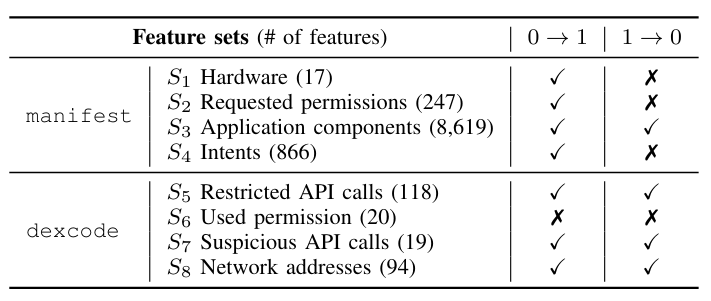

In [11]:
OPERATOR = {
    # insert
    0: "insert",
    # remove
    1: "remove"
}

INSTR_ALLOWED = {
    OPERATOR[0]: [COMP['Permission'],
                  COMP['Activity'],
                  COMP['Service'],
                  COMP['Receiver'],
                  COMP['Hardware'],
                  COMP['Intentfilter'],
                  COMP['Android_API'],
                  COMP['User_String']
                  ],
    OPERATOR[1]: [COMP['Activity'],
                  COMP['Service'],
                  COMP['Receiver'],
                  COMP['Provider'],
                  COMP['Android_API'],
                  COMP['User_String']
                  ]
}



def get_mod_array(vocab, word_catagory_dict):
    """
    get binary indicator of showing the feature can be either modified or not
    '1' means modifiable and '0' means not
    """
    insertion_array = []
    removal_array = []

    insertion_array = np.zeros(len(vocab), )
    removal_array = np.zeros(len(vocab), )

    for i, word in enumerate(vocab):
        cat = word_catagory_dict.get(word)
        if cat is not None:
            if cat in INSTR_ALLOWED[OPERATOR[0]]:
                insertion_array[i] = 1
            else:
                insertion_array[i] = 0
            if cat in INSTR_ALLOWED[OPERATOR[1]]:
                removal_array[i] = 1
            else:
                removal_array[i] = 0
        else:
            raise ValueError("Incompatible value.")

    return insertion_array, removal_array

In [12]:
insertion_array, removal_array = get_mod_array(vocab, vocab_type_dic)

print(sum(insertion_array))
print(sum(removal_array))

9943.0
8856.0


In [13]:
# File path to save the numbers
file_path = 'insertion_array.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Use pickle to dump the list of numbers
    pickle.dump(insertion_array, file)

print("Numbers saved to:", file_path)


# File path to save the numbers
file_path = 'removal_array.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Use pickle to dump the list of numbers
    pickle.dump(removal_array, file)

print("Numbers saved to:", file_path)


Numbers saved to: insertion_array.pkl
Numbers saved to: removal_array.pkl


In [14]:
from collections import Counter

# Count the occurrences of each element
element_counts = Counter(vocab_type)

# Print the counts
for element, count in element_counts.items():
    print(f"{element}: {count}")


permission: 247
intent-filter: 872
android_api: 129
java_api: 2
const-string: 94
not_defined: 6
service: 977
receiver: 1201
activity: 6406
hardware: 17
provider: 49


In [15]:
# Specific value to search for
specific_value = 'not_defined'

# Initialize a list to store keys with the specific value
keys_with_specific_value = []

# Iterate over the items of the dictionary
for key, value in vocab_type_dic.items():
    # Check if the value matches the specific value
    if value == specific_value:
        # Add the key to the list
        keys_with_specific_value.append(key)

# Print the keys with the specific value
print(keys_with_specific_value)

['RestrictedApiList_android.widget.VideoView.start', 'SuspiciousApiList_system/bin/su', 'RestrictedApiList_android.media.MediaPlayer.release', 'RestrictedApiList_android.widget.VideoView.pause', 'RestrictedApiList_android.app.Activity.setWallpaper', 'SuspiciousApiList_Landroid/app/Application.getSystemService']
